In [ ]:
!pip install transformers

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import pandas as pd
import transformers
from transformers import pipeline

In [ ]:
udf = pd.read_csv('../content/gdrive/My Drive/data/2023/sentiment.csv')
udf = udf.dropna(subset=['comments'])

In [ ]:
positive_samples = udf[udf['sentiment'] == 'positive'] #Filtering samples
negative_samples = udf[udf['sentiment'] == 'negative']

positive_sampled = positive_samples.sample(n=4100, random_state=56) #Keep only a certain amount of positives

df = pd.concat([positive_sampled, negative_samples]) #Make a dataframe with the selected positives and negatives

df = df.sample(frac=1, random_state=42).reset_index(drop=True) #Mix the positions so that not all negatives are at the bottom

In [ ]:
df['sentiment'].value_counts() #~70-30 positive/negative distribution

sentiment
positive    4100
negative    1267
Name: count, dtype: int64

In [ ]:
dfc = pd.read_csv('../content/gdrive/My Drive/data/2023/june/reviews.csv')

In [ ]:
dfc = pd.read_csv('../content/gdrive/My Drive/data/2023/march/reviews.csv')

In [ ]:
dfc = pd.read_csv('../content/gdrive/My Drive/data/2023/september/reviews.csv')

In [ ]:
#@title Clean data
import re

def remove_non_english(text):   #Removing non english chars
    if isinstance(text, str):
        return re.sub(r'[^a-zA-Z\s]', '', text)
    return text

dfc['comments'] = dfc['comments'].apply(remove_non_english)

dfc = dfc.dropna(subset=['comments'])   #Remove empty rows
dfc = dfc[dfc['comments'].str.strip() != '']

In [ ]:
dfc['comments'] = dfc['comments'].astype(str).dropna()

In [ ]:
dfc['comments'] = dfc['comments'].str.lower() #Make everything lowercase

In [ ]:
stop = stopwords.words('english')
def remove_stopwords(text):   #Remove all english stopwords
    return ' '.join([word for word in text.split() if word.lower() not in stop])

dfc['comments'] = dfc['comments'].apply(remove_stopwords)

In [ ]:
#@title Use pre-trained model to get sentiment for out dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification

distilled_student_sentiment_classifier = pipeline(    #classifier
    model="lxyuan/distilbert-base-multilingual-cased-sentiments-student"
)

tokenizer = AutoTokenizer.from_pretrained("lxyuan/distilbert-base-multilingual-cased-sentiments-student")
model = AutoModelForSequenceClassification.from_pretrained("lxyuan/distilbert-base-multilingual-cased-sentiments-student")

sentiment_analysis = pipeline("sentiment-analysis",model=model, tokenizer = tokenizer, max_length = 512, truncation = True) #sentiment analysis pipeline

def get_sentiment(text):  #Function to get sentiment
    result = sentiment_analysis(text)
    return result[0]['label']


sampled_dfc = dfc.sample(n=1000, random_state=44)  #Sample n random dataframe entries

sampled_dfc['sentiment'] = sampled_dfc['comments'].apply(get_sentiment) #Get the sentiment for those entries

In [ ]:
sampled_dfc.to_csv('../content/gdrive/My Drive/data/2023/sentiment3.csv')

In [ ]:
df_count = sampled_dfc['sentiment'].value_counts().to_frame() #count all values and place them in dataframe df_count
df_count

,count
sentiment,
positive,934
negative,64
neutral,2


<Axes: title={'center': 'March review counts'}, xlabel='sentiment'>

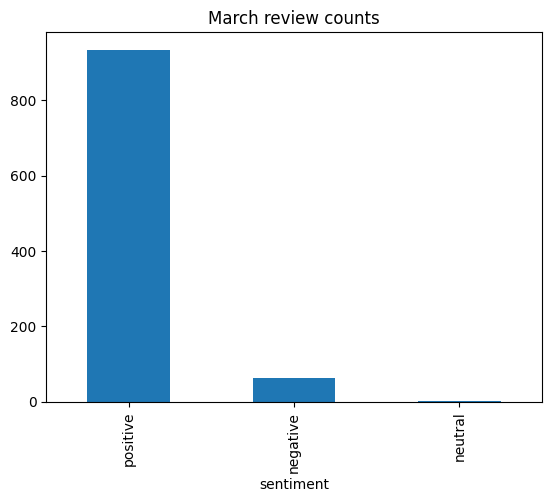

In [ ]:
#@title Review sentiment based as time passes

import matplotlib.pyplot as plt
df1 = pd.read_csv('../content/gdrive/My Drive/data/2023/sentiment3.csv')
df2 = pd.read_csv('../content/gdrive/My Drive/data/2023/sentiment.csv')
df3 = pd.read_csv('../content/gdrive/My Drive/data/2023/sentiment2.csv')
df2_sampled = df2.sample(n=1000, random_state=44)

df1_count = df1['sentiment'].value_counts().to_frame()
df2_sampled_count = df2_sampled['sentiment'].value_counts().to_frame()
df3_count = df3['sentiment'].value_counts().to_frame()

df1_count['count'].plot(kind='bar', title='March review counts')



<Axes: title={'center': 'June review counts'}, xlabel='sentiment'>

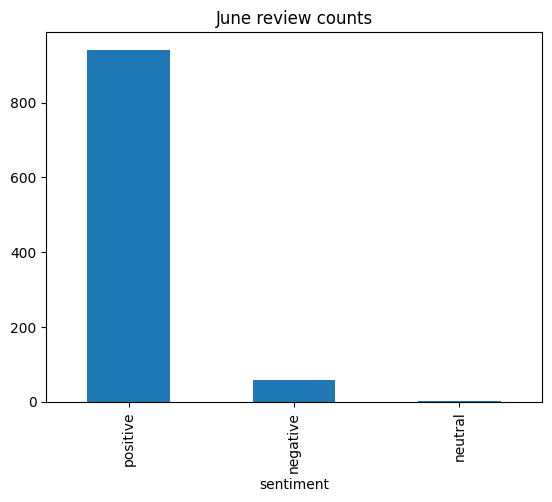

In [ ]:
df2_sampled_count['count'].plot(kind='bar', title='June review counts')

<Axes: title={'center': 'September review counts'}, xlabel='sentiment'>

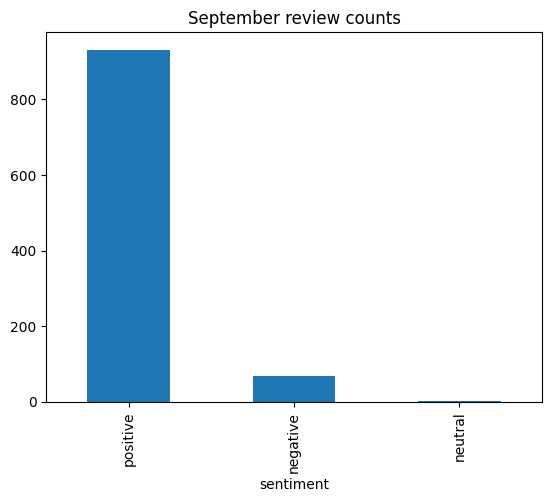

In [ ]:
df3_count['count'].plot(kind='bar', title='September review counts')

In [ ]:
#@title Libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import pickle
from sklearn.model_selection import cross_val_score
from gensim.models import Word2Vec
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# @title TF-IDF Features

path = '../content/gdrive/My Drive/data/2023/tfidf_features.pkl'

vectorizer = TfidfVectorizer(max_features=500)  #TF-IDF vectorizer
X = vectorizer.fit_transform(df['comments'])  #Vectorization of the data
y = df['sentiment']

with open('tfidf_features.pkl', 'wb') as f:   #Save the features in a *.pkl file
    pickle.dump((X, y), f)

In [ ]:
# @title Word Embedding features
tokenized_comments = df['comments'].apply(lambda x: x.split()) #Tokenizing the reviews column

w2v_model = Word2Vec(sentences=tokenized_comments, vector_size=100, window=5, min_count=1, workers=4) #w2v model training

def average_word_vectors(words, model, vocabulary, num_features): #Function for calculating the average vector of all the words in a sentence
    feature_vector = np.zeros((num_features,), dtype="float64")
    nwords = 0.
    for word in words:
        if word in vocabulary:
            nwords += 1.  #counts words
            feature_vector = np.add(feature_vector, model.wv[word])
    if nwords:
        feature_vector = np.divide(feature_vector, nwords) #divides vectors by the word count to get average sentence vector
    return feature_vector

vocabulary = set(w2v_model.wv.index_to_key)

X = np.array([average_word_vectors(comment, w2v_model, vocabulary, 100) for comment in tokenized_comments])  #Vectorize the tokenized comments
y = df['sentiment']


path = '../content/gdrive/My Drive/data/2023/word_emb_features.pkl'

with open('word_emb_features.pkl', 'wb') as f:   #Save the word embedding features in a *.pkl file
    pickle.dump((X, y), f)

In [ ]:
#@title TF-IDF SVM
#We are going to use TF-IDF features and an SVM classifier
with open('tfidf_features.pkl', 'rb') as f:  #Load saved TF-IDF features
    X, y = pickle.load(f)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)  #Split into test and train data

svm_model = SVC(kernel='linear') #load svm model

cv_scores = cross_val_score(svm_model, X_train, y_train, cv=10, scoring='accuracy') #do 10-fold CV on training set
y_train_pred_cv = cross_val_predict(svm_model, X_train, y_train, cv=10)

svm_model.fit(X_train, y_train) #Train the model on the dataset

y_test_pred = svm_model.predict(X_test) #Make predictions on the test set

print(f'Classifier: SVM Model')
print('10-Fold Cross-Validation:')
print(f'Cross-Validation Accuracy on Training Set: {cv_scores.mean()}')
print(classification_report(y_train, y_train_pred_cv))  #10-fold cv performance metrics
print(f'Accuracy on Test Set: {accuracy_score(y_test, y_test_pred)}') #Prediction accuracy on the test set

Classifier: SVM Model
10-Fold Cross-Validation:
Cross-Validation Accuracy on Training Set: 0.862800455358595
              precision    recall  f1-score   support

    negative       0.73      0.66      0.69      1013
    positive       0.90      0.93      0.91      3280

    accuracy                           0.86      4293
   macro avg       0.82      0.79      0.80      4293
weighted avg       0.86      0.86      0.86      4293

Accuracy on Test Set: 0.87243947858473


In [ ]:
#@title Word Embedding SVM
#Same as before except we use Word Embedding features this time
with open('word_emb_features.pkl', 'rb') as f:  #Load saved word embedding features
    X, y = pickle.load(f)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)  #Split into test and train data

svm_model = SVC(kernel='linear')

cv_scores = cross_val_score(svm_model, X_train, y_train, cv=10, scoring='accuracy')
y_train_pred_cv = cross_val_predict(svm_model, X_train, y_train, cv=10)

svm_model.fit(X_train, y_train)

y_test_pred = svm_model.predict(X_test)

print(f'Classifier: SVM Model')
print('10-Fold Cross-Validation:')
print(f'Cross-Validation Accuracy on Training Set: {cv_scores.mean()}')
print(classification_report(y_train, y_train_pred_cv, zero_division = 0))
print(f'Accuracy on Test Set: {accuracy_score(y_test, y_test_pred)}')

Classifier: SVM Model
10-Fold Cross-Validation:
Cross-Validation Accuracy on Training Set: 0.8162102238846426
              precision    recall  f1-score   support

    negative       0.59      0.69      0.64      1013
    positive       0.90      0.85      0.88      3280

    accuracy                           0.82      4293
   macro avg       0.75      0.77      0.76      4293
weighted avg       0.83      0.82      0.82      4293

Accuracy on Test Set: 0.8426443202979516


In [ ]:
#@title TF-IDF Random Forest Classifier
#This time we use TF-IDF but instead of SVM we use a Random Forest Classifier
with open('tfidf_features.pkl', 'rb') as f:  #Load saved TF-IDF features
    X, y = pickle.load(f)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)  #Split into test and train data

random_forest = RandomForestClassifier()

cv_scores = cross_val_score(random_forest, X_train, y_train, cv=10, scoring='accuracy')
y_train_pred_cv = cross_val_predict(random_forest, X_train, y_train, cv=10)

random_forest.fit(X_train, y_train)

y_test_pred = random_forest.predict(X_test)

print(f'Classifier: Random Forest Model')
print('10-Fold Cross-Validation:')
print(f'Cross-Validation Accuracy on Training Set: {cv_scores.mean()}')
print(classification_report(y_train, y_train_pred_cv))
print(f'Accuracy on Test Set: {accuracy_score(y_test, y_test_pred)}')

Classifier: Random Forest Model
10-Fold Cross-Validation:
Cross-Validation Accuracy on Training Set: 0.8490464574185503
              precision    recall  f1-score   support

    negative       0.71      0.63      0.67      1013
    positive       0.89      0.92      0.91      3280

    accuracy                           0.85      4293
   macro avg       0.80      0.78      0.79      4293
weighted avg       0.85      0.85      0.85      4293

Accuracy on Test Set: 0.8752327746741154


In [ ]:
#@title Word Embedding Random Forest Classifier
#Random forest classifier but with word embedding instead
with open('word_emb_features.pkl', 'rb') as f:  #Load saved word embedding features
    X, y = pickle.load(f)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)  #Split into test and train data

random_forest = RandomForestClassifier()

cv_scores = cross_val_score(random_forest, X_train, y_train, cv=10, scoring='accuracy')
y_train_pred_cv = cross_val_predict(random_forest, X_train, y_train, cv=10)

random_forest.fit(X_train, y_train)

y_test_pred = random_forest.predict(X_test)

print(f'Classifier: Random Forest Model')
print('10-Fold Cross-Validation:')
print(f'Cross-Validation Accuracy on Training Set: {cv_scores.mean()}')
print(classification_report(y_train, y_train_pred_cv))
print(f'Accuracy on Test Set: {accuracy_score(y_test, y_test_pred)}')

Classifier: Random Forest Model
10-Fold Cross-Validation:
Cross-Validation Accuracy on Training Set: 0.8404423483493251
              precision    recall  f1-score   support

    negative       0.67      0.64      0.65      1013
    positive       0.89      0.90      0.90      3280

    accuracy                           0.84      4293
   macro avg       0.78      0.77      0.77      4293
weighted avg       0.84      0.84      0.84      4293

Accuracy on Test Set: 0.8519553072625698


In [ ]:
#@title TF-IDF KNN
#Use of KNN classifier and the TF-IDF features file
with open('tfidf_features.pkl', 'rb') as f:  #Load saved features
    X, y = pickle.load(f)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)  #Split into test and train data

KNN = KNeighborsClassifier(n_neighbors=2)

cv_scores = cross_val_score(KNN, X_train, y_train, cv=10, scoring='accuracy')
y_train_pred_cv = cross_val_predict(KNN, X_train, y_train, cv=10)

KNN.fit(X_train, y_train)

y_test_pred = KNN.predict(X_test)

print(f'Classifier: KNN Model')
print('10-Fold Cross-Validation:')
print(f'Cross-Validation Accuracy on Training Set: {cv_scores.mean()}')
print(classification_report(y_train, y_train_pred_cv))
print(f'Accuracy on Test Set: {accuracy_score(y_test, y_test_pred)}')

Classifier: KNN Model
10-Fold Cross-Validation:
Cross-Validation Accuracy on Training Set: 0.41043096438445276
              precision    recall  f1-score   support

    negative       0.27      0.89      0.42      1013
    positive       0.89      0.26      0.40      3280

    accuracy                           0.41      4293
   macro avg       0.58      0.58      0.41      4293
weighted avg       0.74      0.41      0.41      4293

Accuracy on Test Set: 0.41154562383612664


In [ ]:
#@title Word Embedding KNN
#Use of the KNN classifier and the word embedding file instead
with open('word_emb_features.pkl', 'rb') as f:  #Load saved features
    X, y = pickle.load(f)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)  #Split into test and train data

KNN = KNeighborsClassifier(n_neighbors=2)

cv_scores = cross_val_score(KNN, X_train, y_train, cv=10, scoring='accuracy')
y_train_pred_cv = cross_val_predict(KNN, X_train, y_train, cv=10)

KNN.fit(X_train, y_train)

y_test_pred = KNN.predict(X_test)

print(f'Classifier: KNN Model')
print('10-Fold Cross-Validation:')
print(f'Cross-Validation Accuracy on Training Set: {cv_scores.mean()}')
print(classification_report(y_train, y_train_pred_cv))
print(f'Accuracy on Test Set: {accuracy_score(y_test, y_test_pred)}')

Classifier: KNN Model
10-Fold Cross-Validation:
Cross-Validation Accuracy on Training Set: 0.783840190816935
              precision    recall  f1-score   support

    negative       0.53      0.76      0.62      1013
    positive       0.92      0.79      0.85      3280

    accuracy                           0.78      4293
   macro avg       0.72      0.78      0.74      4293
weighted avg       0.82      0.78      0.80      4293

Accuracy on Test Set: 0.792364990689013
